## Prediction of COVID-19 using CXR Images
### Phanupong Pattanachai

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torchvision.io import read_image
from torchvision.utils import save_image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# GLOBAL VARIABLE
DATA_PATH = './COVID-19_Radiography_Dataset'
QU_EX_DATA_PATH = './COVID_QU_EX_dataset'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
TRAIN_RATIO = 0.8
IMAGE_SIZE = 256
CHANNELS_IMG = 3
NUM_CLASSES = 1
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 100
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_VGG = 'vgg.pth.tar'
BEST_CHECKPOINT_VGG = 'best_vgg.pth.tar'
CHECKPOINT_INCEPTION = 'inception.pth.tar'
BEST_CHECKPOINT_INCEPTION = 'best_inception.pth.tar'
BEST_CHECKPOINT_DEEPCOVNET = 'best_deepcovnet.pth.tar'
CHECKPOINT_DEEPCOVNET = 'deepcovnet.pth.tar'

### Data Collection and Preprocessing

- COVID-19 Radiography Database: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
- COVID-QU-Ex Database: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu

In [3]:
class COVID_Dataset(Dataset):
    def __init__(self, root_dir=DATA_PATH, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'COVID'] # 0 = Normal, 1 = COVID
        self.images = []
        self.labels = []
        
        # load the images from the directories
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name, 'images')
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = read_image(self.images[index])
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [4]:
# count the number of 0s in the dataset
def count_normal_covid(dataset):
    normal = 0
    covid = 0
    for label in dataset.labels:
        if label == 0:
            normal += 1
        else:
            covid += 1
    return normal, covid


In [5]:
# Making sure the custom dataset is working
dataset = COVID_Dataset(root_dir=DATA_PATH, transform=None)
len(dataset)

normal, covid = count_normal_covid(dataset)
print(f'NonCovid: {normal}, COVID: {covid} , Total: {normal + covid}')

NonCovid: 10192, COVID: 3616 , Total: 13808


Image shape: torch.Size([1, 299, 299])


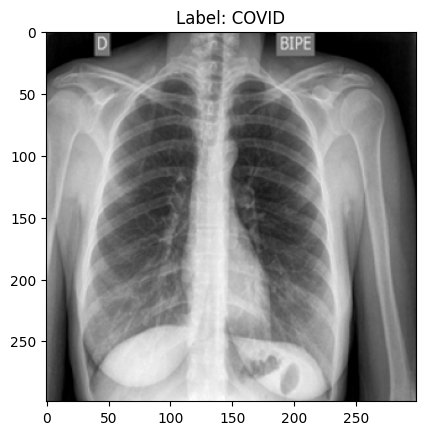

In [166]:
# Access an image and its label
image, label = dataset[12000]
print(f"Image shape: {image.shape}")

# Visualize the Image
plt.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title(f"Label: {dataset.classes[label]}")
plt.show()

In [6]:
13808 * 0.8

11046.400000000001

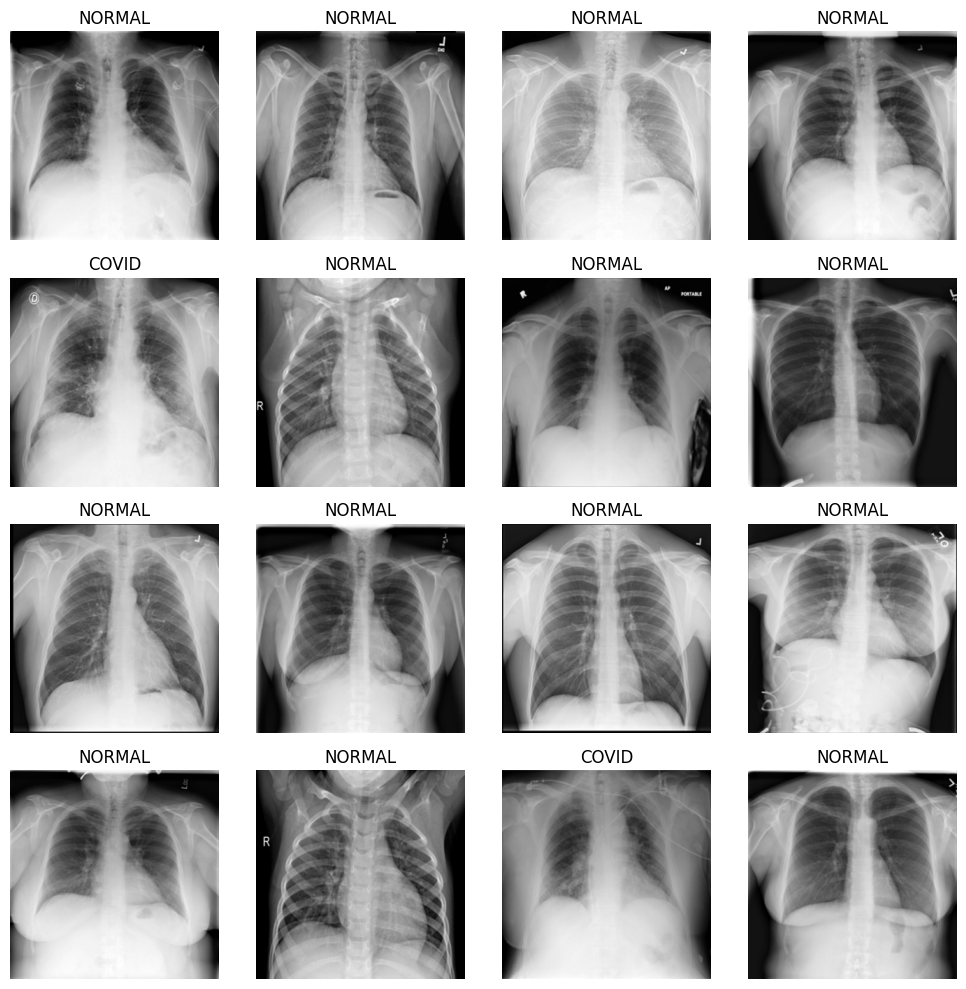

In [167]:
# Cerate a data loader
covid_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
images, labels = next(iter(covid_dataloader))   

# Visualize the images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
    ax.set_title(f"{dataset.classes[labels[i].item()]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Split Data into Training and Validation Sets & Data Loaders

In [168]:
## DEFINE TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
dataset = COVID_Dataset(root_dir=DATA_PATH, transform=transform)

# Calculate the sizes of the training and testing datasets
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Train Dataset Size: {len(train_dataset)} \nTest Dataset Size: {len(test_dataset)}")

# Create DataLoaders for the training and etsting datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train Dataset Size: 11046 
Test Dataset Size: 2762


### Models

#### Custom VGG-16 Model

In [169]:
class CustomVGG(nn.Module):
    def __init__(self, num_channels=3, num_classes=1):
        super(CustomVGG, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        
        # modify the first convolutional layer to accept a single-channel input
        vgg16.features[0] = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
        
        # replace the original classifier part with a new classifier for binary classification
        num_features = vgg16.classifier[0].in_features
        vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes, bias=True),
        )
        
        self.model = vgg16
    
    def forward(self, x):
        # replicate the single channel to make it a 3 channel input
        x = x.repeat(1, 3, 1, 1)
        return self.model(x)

In [170]:
custom_vgg = CustomVGG(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
x = torch.rand((1, 1, 256, 256)).to(DEVICE)
y_pred = custom_vgg(x)
print(y_pred)

tensor([[0.0366]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [171]:
# determine the number of parameters
print(sum(x.reshape(-1).shape[0] for x in custom_vgg.parameters()))

134264641


#### InceptionResNet

In [172]:
class CustomInceptionV3(nn.Module):
    def __init__(self, num_channels=3, num_classes=1):
        super(CustomInceptionV3, self).__init__()
        # Load the pretrained Inception v3 model
        inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        
        # modify the first convolutional layer to accept a single-channel input
        inception_v3.Conv2d_1a_3x3 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=2)
        
        # replace the original classifier with a new classifier for binary classification
        num_features = inception_v3.fc.in_features
        inception_v3.fc = nn.Linear(num_features, num_classes)
        
        # set the model to only return the main output
        inception_v3.aux_logits = False
        
        self.model = inception_v3
        
    def forward(self, x):
        # replicate the single channel to make it a 3 channel input
        x = x.repeat(1, 3, 1, 1)
        # resize the input image to 299x299 which is required input size for inception v3 model
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        return self.model(x)

In [173]:
inception_v3 = CustomInceptionV3(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
inception_v3.eval()
x = torch.rand((1, 1, 256, 256)).to(DEVICE)
y_pred = inception_v3(x)
print(y_pred)

tensor([[0.1916]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [174]:
num_params_inception = sum(x.reshape(-1).shape[0] for x in inception_v3.parameters())
print(f"Inception Model has {num_params_inception} parameters")


Inception Model has 25114281 parameters


#### DeepCOVNet

In [175]:
class DeepCOVNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=1):
        super(DeepCOVNet, self).__init__()
        # the input layer in the paper expects 224 x 224 x 3 images
        # add padding of 1 to the convolutional layers to keep the spatial dimensions the same; the paper does not use any paddings
        self.model = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=0), # 222 x 222 x 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 111 x 111 x 32
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, 3, 1, 0), # 109 x 109 x 64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 54 x 54 x 64
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 3, 1, 0), # 52x 52 x 128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1), # 51 x 51 x 128 because paper uses stride of 1
            nn.Dropout(0.25),
            
            nn.Flatten(),
            nn.Linear(51 * 51 * 128, 64),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        # replicate the single channel to make it a 3 channel input; returns the logit because uses BCEWithLogitsLoss(combined sigmoid and BCE) during training
        x = x.repeat(1, 3, 1, 1)
        return self.model(x)

In [176]:
# Create an instance of the DeepCOVNet model and run a sample input through it
x = torch.rand((1, 1, 224, 224)).to(DEVICE)
model = DeepCOVNet(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
y_pred = model(x)
print(y_pred, y_pred.shape)

tensor([[0.0365]], device='cuda:0', grad_fn=<AddmmBackward0>) torch.Size([1, 1])


### Train

In [177]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpiont...")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoing...")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # avoid optimizer having older checkpoint learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def save_matrices(file_loc, epochs, train_losses, train_accs, valid_losses, valid_accs):
     # save the training and validation losses and accuracy to a csv file
    import csv
    epochs_list = [i for i in range(epochs)]

    print("Saving the performance matrices...")
    with open(file_loc, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
        for i in range(epochs):
            writer.writerow([epochs_list[i], train_losses[i], train_accs[i], valid_losses[i], valid_accs[i]])


def load_matrices(file_loc):
    # load the training and validation losses and accuracy from a csv file
    import csv
    epochs = []
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    with open(file_loc, mode='r') as file:
        reader = csv.reader(file)
        next(reader) # skip the header
        for row in reader:
            epochs.append(int(row[0]))
            train_losses.append(float(row[1]))
            train_accs.append(float(row[2]))
            valid_losses.append(float(row[3]))
            valid_accs.append(float(row[4]))
    
    return epochs, train_losses, train_accs, valid_losses, valid_accs

In [178]:
def train(model, data_loader, optimizer, loss_fnc, scaler, epoch_num):
    # the main training loop
    loop = tqdm(data_loader, leave=True)
    model.train()
    losses = []
    accs = []
    loop.set_description(f"Epoch {epoch_num}")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE).float()
        with torch.cuda.amp.autocast():        
            # forward pass
            y_pred = model(x).squeeze()
            loss = loss_fnc(y_pred, y)
            
            # backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # logging
            acc = ((y_pred > 0.5).float() == y).float().mean()
            loop.set_postfix(loss=loss.item(), acc=acc.item())
            losses.append(loss.item())
            accs.append(acc.item())
            
    return losses, accs

#### Train VGG16

In [179]:
def train_vgg16():
    ## DEFINE TRANSFORMATIONS
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create a new dataset with the transformations
    dataset = COVID_Dataset(root_dir=DATA_PATH, transform=transform)

    # Calculate the sizes of the training and testing datasets
    train_size = int(TRAIN_RATIO * len(dataset))
    test_size = len(dataset) - train_size

    # Split the dataset into training and testing datasets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    print(f"Train Dataset Size: {len(train_dataset)} \nTest Dataset Size: {len(test_dataset)}")

    # Create DataLoaders for the training and etsting datasets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # intialize the model
    model = CustomVGG(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)

    # intialize the optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # intialize the loss function; binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross entropy loss; removes the sigmoid from the last layer
    scaler = torch.cuda.amp.GradScaler()

    # load the model checkpoint if it exists
    if LOAD_MODEL:
        load_checkpoint(BEST_CHECKPOINT_VGG, model, optimizer, LEARNING_RATE)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_loss = float('inf')
    print(f"Start Training on {DEVICE}...")
    for epoch in range(NUM_EPOCHS):
        loss, acc = train(model, train_loader, optimizer, criterion, scaler, epoch)
        # compute the average loss for the epoch
        train_losses.append(sum(loss)/len(loss))
        train_accs.append(sum(acc)/len(acc))

        # evaluate the accuracy at the end of each epoch
        model.eval()
        valid_loss = []
        valid_acc = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE).float()
                y_pred = model(x).squeeze()
                loss = criterion(y_pred, y)
                acc = ((y_pred > 0.5).float() == y).float().mean()
                valid_loss.append(loss.item())
                valid_acc.append(acc.item())
        # compute the average validation loss and accuracy for this epoch
        valid_losses.append(sum(valid_loss)/len(valid_loss))
        valid_accs.append(sum(valid_acc)/len(valid_acc))
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]:.4f}")
        
        # save the best model checkpoint
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            save_checkpoint(model, optimizer, filename=BEST_CHECKPOINT_VGG)
        # save the model checkpoint every 5 epochs
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(model, optimizer, filename=CHECKPOINT_VGG)
            
    # Save the performance matrices of the VGG 16 model after fine-tuning
    save_matrices('vgg16_performance.csv', NUM_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)
    

In [180]:
# Set the flag to true to the train the vgg model
TRAIN_VGG = False

if TRAIN_VGG:
    train_vgg16()

#### Train InceptionV3

In [181]:
def train_inception():
    ## DEFINE TRANSFORMATIONS
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create a new dataset with the transformations
    dataset = COVID_Dataset(root_dir=DATA_PATH, transform=transform)

    # Calculate the sizes of the training and testing datasets
    train_size = int(TRAIN_RATIO * len(dataset))
    test_size = len(dataset) - train_size

    # Split the dataset into training and testing datasets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    print(f"Train Dataset Size: {len(train_dataset)} \nTest Dataset Size: {len(test_dataset)}")

    # Create DataLoaders for the training and etsting datasets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # intialize the model
    model_inception = CustomInceptionV3(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)

    # intialize the optimizers
    optimizer = torch.optim.Adam(model_inception.parameters(), lr=LEARNING_RATE)

    # intialize the loss function; binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross entropy loss; removes the sigmoid from the last layer
    scaler = torch.cuda.amp.GradScaler()

    # load the model checkpoint if it exists
    if LOAD_MODEL:
        load_checkpoint(BEST_CHECKPOINT_INCEPTION, model_inception, optimizer, LEARNING_RATE)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_loss = float('inf')
    print(f"Start Training on {DEVICE}...")
    for epoch in range(NUM_EPOCHS):
        loss, acc = train(model_inception, train_loader, optimizer, criterion, scaler, epoch)
        # compute the average loss for the epoch
        train_losses.append(sum(loss)/len(loss))
        train_accs.append(sum(acc)/len(acc))

        # evaluate the accuracy at the end of each epoch
        model_inception.eval()
        valid_loss = []
        valid_acc = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE).float()
                y_pred = model_inception(x).squeeze()
                loss = criterion(y_pred, y)
                acc = ((y_pred > 0.5).float() == y).float().mean()
                valid_loss.append(loss.item())
                valid_acc.append(acc.item())
        # compute the average validation loss and accuracy for this epoch
        valid_losses.append(sum(valid_loss)/len(valid_loss))
        valid_accs.append(sum(valid_acc)/len(valid_acc))
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]:.4f}")
        
        # save the best model checkpoint
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            save_checkpoint(model_inception, optimizer, filename=BEST_CHECKPOINT_INCEPTION)
        # save the model checkpoint every 5 epochs
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(model_inception, optimizer, filename=CHECKPOINT_INCEPTION)
            
            
    # Save the performance matrices of the INCEPTION model after fine-tuning
    save_matrices('inception_performance.csv', NUM_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [182]:
# Set the flag to true to the train the inception model
TRAIN_INCEPTION = False

if TRAIN_INCEPTION:
    train_inception()

#### Train DeepCOVNet

In [183]:
def train_DeepCOVNet():
    ## DEFINE TRANSFORMATIONS
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    # Create a new dataset with the transformations
    dataset = COVID_Dataset(root_dir=DATA_PATH, transform=transform)

    # Calculate the sizes of the training and testing datasets
    train_size = int(TRAIN_RATIO * len(dataset))
    test_size = len(dataset) - train_size

    # Split the dataset into training and testing datasets
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    print(f"Train Dataset Size: {len(train_dataset)} \nTest Dataset Size: {len(test_dataset)}")

    # Create DataLoaders for the training and etsting datasets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # intialize the model
    model = DeepCOVNet(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)

    # intialize the optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # intialize the loss function; binary cross entropy loss
    criterion = nn.BCEWithLogitsLoss() # combines sigmoid and binary cross entropy loss; removes the sigmoid from the last layer
    scaler = torch.cuda.amp.GradScaler()

    # load the model checkpoint if it exists
    if LOAD_MODEL:
        load_checkpoint(BEST_CHECKPOINT_DEEPCOVNET, model, optimizer, LEARNING_RATE)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_loss = float('inf')
    print(f"Start Training on {DEVICE}...")
    for epoch in range(NUM_EPOCHS):
        loss, acc = train(model, train_loader, optimizer, criterion, scaler, epoch)
        # compute the average loss for the epoch
        train_losses.append(sum(loss)/len(loss))
        train_accs.append(sum(acc)/len(acc))

        # evaluate the accuracy at the end of each epoch
        model.eval()
        valid_loss = []
        valid_acc = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE).float()
                y_pred = model(x).squeeze()
                loss = criterion(y_pred, y)
                acc = ((y_pred > 0.5).float() == y).float().mean()
                valid_loss.append(loss.item())
                valid_acc.append(acc.item())
        # compute the average validation loss and accuracy for this epoch
        valid_losses.append(sum(valid_loss)/len(valid_loss))
        valid_accs.append(sum(valid_acc)/len(valid_acc))
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]:.4f}")
        
        # save the best model checkpoint
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            save_checkpoint(model, optimizer, filename=BEST_CHECKPOINT_DEEPCOVNET)
        # save the model checkpoint every 5 epochs
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(model, optimizer, filename=CHECKPOINT_DEEPCOVNET)
            
    # Save the performance matrices of the VGG 16 model after fine-tuning
    save_matrices('deepCOVNet_performance.csv', NUM_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [184]:
# set the flag to true to train the DeepCOVNet model
TRAIN_DEEPCOVNET = False

if TRAIN_DEEPCOVNET:
    train_DeepCOVNet()

### Visualize

In [185]:
def visualize_performance(df, model_name):
    # given a dataframe containing the performance matrices during trainig, loading them into lists and visualize the results
    epoch_list = df['Epoch'].tolist()
    train_loss = df['Train Loss'].tolist()
    train_acc = df['Train Acc'].tolist()
    val_loss = df['Val Loss'].tolist()
    val_acc = df['Val Acc'].tolist()
    
    # plot the training and validation losses and training and validation accuracy using subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(epoch_list, train_loss, label='Train Loss', color='b')
    axes[0].plot(epoch_list, val_loss, label='Val Loss', color='orange')
    axes[0].set_title(f'Training and Validation Loss of {model_name} Model')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(epoch_list, train_acc, label='Train Acc', color='b')
    axes[1].plot(epoch_list, val_acc, label='Val Acc', color='orange')
    axes[1].set_title(f'Training and Validation Accuracy {model_name} Model')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    

def compare_performance(vgg_df, inception_df, covnet_df):
    # given the dataframes containing the performance matrices of the three models, visualize the results
    epoch_list = vgg_df['Epoch'].tolist()
    
    # load the validation accuracy of the three models
    vgg_validation_accuracy = vgg_df['Val Acc'].tolist()
    inception_validation_accuracy =  inception_df['Val Acc'].tolist()
    covnet_validation_accuracy = covnet_df['Val Acc'].tolist()
    
    # plot the validation accuracy of the three models
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_list, vgg_validation_accuracy, label='VGG 16', color='b')
    plt.plot(epoch_list, inception_validation_accuracy, label='Inception V3', color='orange')
    plt.plot(epoch_list, covnet_validation_accuracy, label='DeepCOVNet', color='green')
    plt.title('Validation Accuracy of the Three Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

#### Load Performance Matrices

In [186]:
# Path to the performance matrices
vgg_performance_path = './vgg16_performance.csv'
inception_performance_path = './inception_performance.csv'
deepcovnet_performance_path = './deepCOVNet_performance.csv'

# Load the performance matrices
vgg_performance_df = pd.read_csv(vgg_performance_path)
inception_performance_df = pd.read_csv(inception_performance_path)
deepcovnet_performance_df = pd.read_csv(deepcovnet_performance_path)

#### Visualize Learning Curves

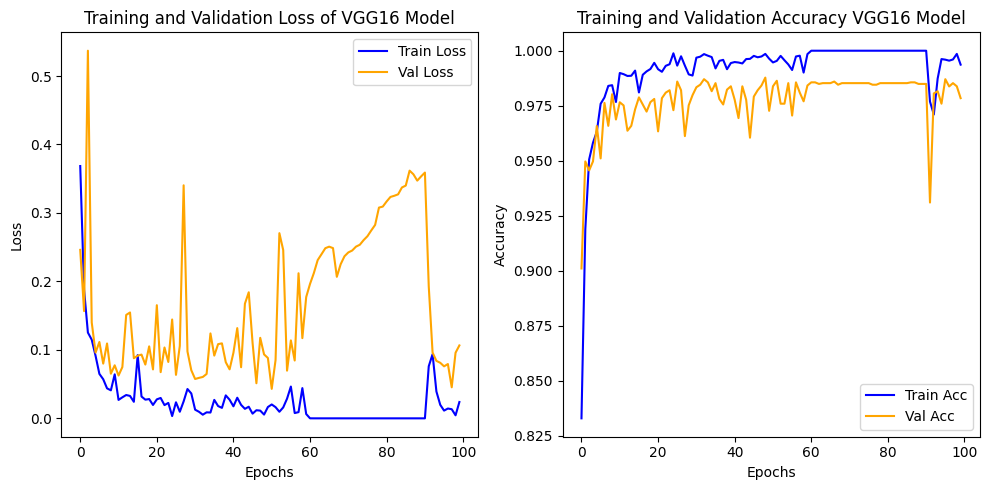

In [187]:
# visualize the performance of vgg16 model
visualize_performance(vgg_performance_df, 'VGG16')

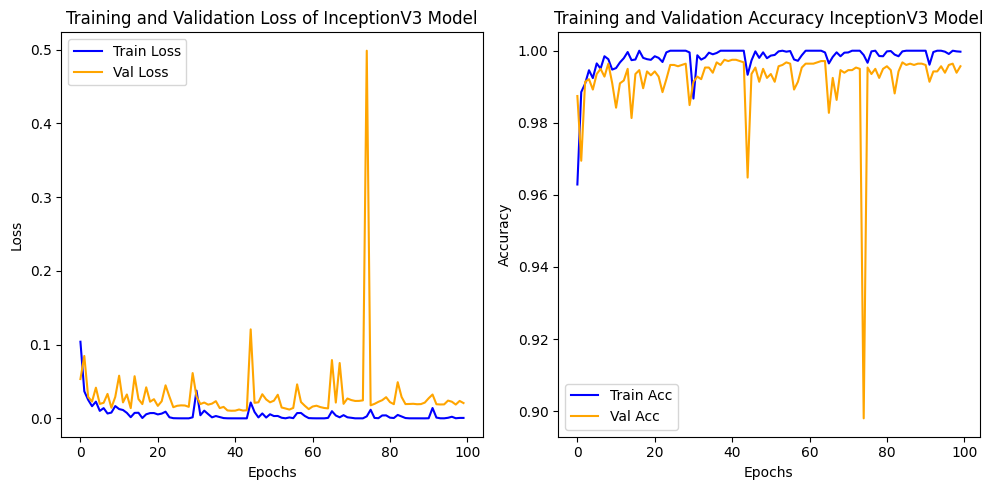

In [188]:
# visualize the performance of inception model
visualize_performance(inception_performance_df, 'InceptionV3')

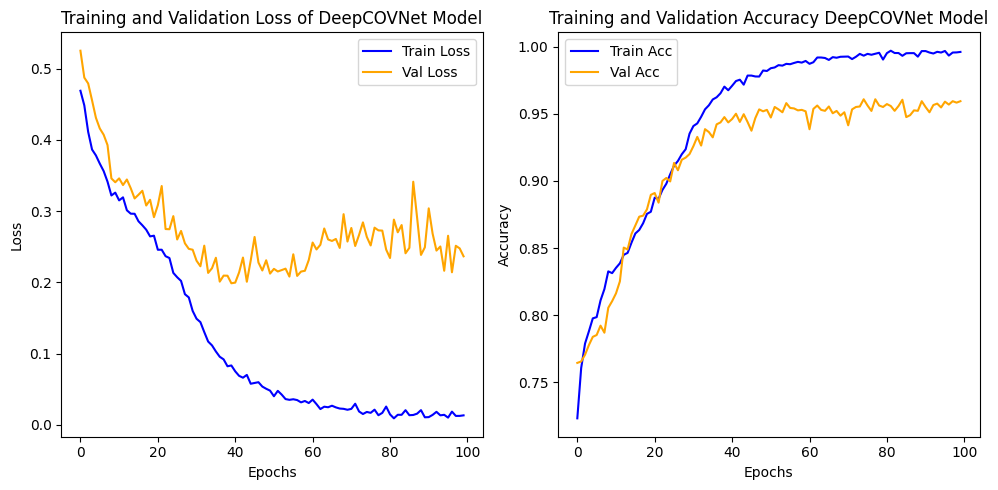

In [189]:
# visualize the performance of the DeepCOVNet model
visualize_performance(deepcovnet_performance_df, 'DeepCOVNet')

#### Compare Performances

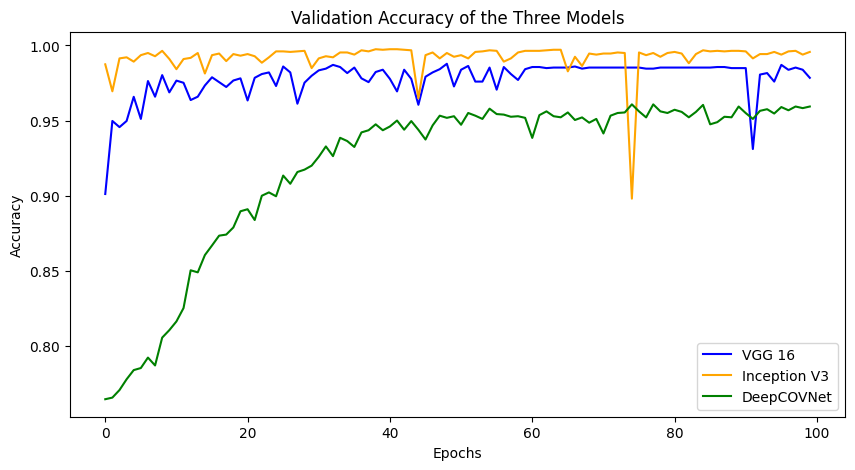

In [190]:
compare_performance(vgg_performance_df, inception_performance_df, deepcovnet_performance_df)

### Evaluate

#### Create Test Dataset
Using the second source of data, COVID-QU-Ex Database: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu

In [226]:
class COVID_QU_EX_Dataset(Dataset):
    def __init__(self, root_dir=QU_EX_DATA_PATH, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Normal', 'COVID_19'] # 0 = Normal, 1 = COVID
        self.images = []
        self.labels = []

        # load the images locations from the directories
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name, 'images')
            for image_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = read_image(self.images[index])
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [193]:
def evaluate_performance(y_true, y_pred):
    # calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    error_rate = 1 - accuracy
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Print the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Error Rate: {error_rate:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    return {
        'accuracy': accuracy,
        'error_rate': error_rate,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    
def test_model(model, test_loader):
    # test the model on the test set
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE).float()
            y_true.extend(y.cpu().numpy())
            y_pred.extend((model(x).squeeze() > 0.5).float().cpu().numpy())
    
    return evaluate_performance(y_true, y_pred)

#### Evaluate VGG16

In [194]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
test_dataset = COVID_QU_EX_Dataset(root_dir=QU_EX_DATA_PATH, transform=transform)

# Create DataLoaders for the training and etsting datasets
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the model checkpoint
vgg16_model = CustomVGG(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
vgg_optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=LEARNING_RATE)
load_checkpoint(BEST_CHECKPOINT_VGG, vgg16_model, vgg_optimizer, LEARNING_RATE)


# Evaluate the Performance
print("=================  VGG16 PERFORMANCE  =================\n")
vgg_performance = test_model(vgg16_model, test_loader)

=> Loading checkpoing...
=================  VGG16 PERFORMANCE  =================



Accuracy: 0.9760
Error Rate: 0.0240
Precision: 0.9982
Recall: 0.9760
F1 Score: 0.9762


#### Evaluate Inception

In [195]:
 ## DEFINE TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
test_dataset = COVID_QU_EX_Dataset(root_dir=QU_EX_DATA_PATH, transform=transform)

# Create DataLoaders for the training and etsting datasets
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the model checkpoint
model_inception = CustomInceptionV3(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
inception_optimizer = torch.optim.Adam(model_inception.parameters(), lr=LEARNING_RATE)
load_checkpoint(BEST_CHECKPOINT_INCEPTION, model_inception, inception_optimizer, LEARNING_RATE)

# Evaluate the Performance
print("=================  INCEPTION PERFORMANCE  =================\n")
inception_performance = test_model(model_inception, test_loader)


=> Loading checkpoing...
=================  INCEPTION PERFORMANCE  =================

Accuracy: 0.9966
Error Rate: 0.0034
Precision: 0.9983
Recall: 0.9966
F1 Score: 0.9966


#### Evaluate DeepCOVNet

In [251]:
# Create a data loader for the DeepCOVNet model which requires reszie of 224 x 224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
test_dataset = COVID_QU_EX_Dataset(root_dir=QU_EX_DATA_PATH, transform=transform)

# Create DataLoaders for the training and etsting datasets
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Load the model using the best checkpoint 
covnet_model = DeepCOVNet(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
covnet_optimizer = torch.optim.Adam(covnet_model.parameters(), lr=LEARNING_RATE)
load_checkpoint(BEST_CHECKPOINT_DEEPCOVNET, covnet_model, covnet_optimizer, LEARNING_RATE)

# Evaluate the Performance
print("=================  DeepCOVNET PERFORMANCE  =================\n")
covnet_performance = test_model(covnet_model, test_loader)

num_params_covnet = sum(x.reshape(-1).shape[0] for x in covnet_model.parameters())
print(f"DeepCOVNet Model has {num_params_covnet} parameters")

=> Loading checkpoing...
=================  DeepCOVNET PERFORMANCE  =================

Accuracy: 0.9394
Error Rate: 0.0606
Precision: 0.9981
Recall: 0.9394
F1 Score: 0.9404
DeepCOVNet Model has 21400769 parameters


#### Visualize Performance using Bar Chart

In [249]:
def plot_performance(model_performance_dict):
    """
    Plots a grouped bar chart for different models and their performance metrics.
    
    Parameters:
    model_performance_dict: Dictionary of models, each containing another dictionary 
                            with performance metrics and their values.
    """
    # Extract model names and metrics
    models = list(model_performance_dict.keys())
    metrics = list(model_performance_dict[models[0]].keys())
    n_models = len(models)
    n_metrics = len(metrics)
    
    # Create an array-like structure from the performance dictionaries
    performance_data = np.array([[model_performance_dict[model][metric] for metric in metrics] for model in models]) * 100

    # Set the position of bars on the x-axis and define bar colors
    bar_width = 0.15
    r = np.arange(n_models)
    colors = ['blue', 'orange', 'green', 'yellow', 'red']
    
    # Make the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for i, metric in enumerate(metrics):
        bar_positions = [x + (bar_width * i) for x in r]
        bars = ax.bar(bar_positions, performance_data[:, i], width=bar_width, color=colors[i], edgecolor='gray', label=metric)
        # Add the metric values on top of the bars
        for bar in bars:
            yval = bar.get_height()
            ax.annotate(f'{yval:.1f}', 
                        (bar.get_x() + bar.get_width() / 2, yval), 
                        ha='center', va='bottom', xytext=(0, 3), 
                        textcoords='offset points')

    # Add xticks on the middle of the group bars
    ax.set_xlabel('Models', fontweight='bold')
    ax.set_xticks([r + bar_width * (n_metrics-1)/2 for r in range(n_models)])
    ax.set_xticklabels(models)
    
    # Create legend & place it at the bottom of the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(models))
    
    # Title and ylim
    ax.set_ylim(0, 100)
    
    plt.suptitle('Performance graph on 100 epochs')
    plt.tight_layout()
    plt.show()

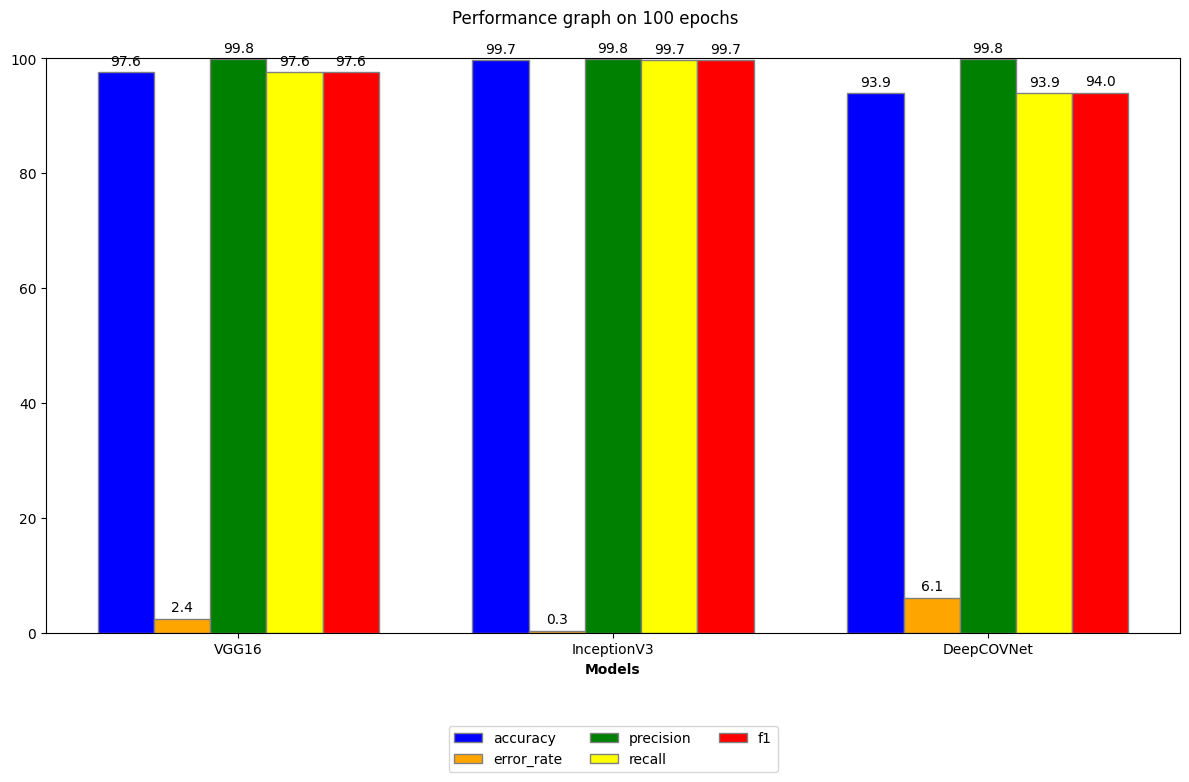

In [247]:
# craete a dictionary containing the model names and their performance metrics
model_performance_dict = {
    'VGG16': vgg_performance,
    'InceptionV3': inception_performance,
    'DeepCOVNet': covnet_performance
}

# visualize the metrics using bar chart
plot_performance(model_performance_dict)

### Predicitng using Trained Model

In [225]:
def display_images_with_probabilities(model, data_loader):
    class_names = ['Non-COVID', 'COVID']
    model.eval()
    # Get the first batch of images from the loader
    images, labels = next(iter(data_loader))
    images = images.to(DEVICE)
    
    # Make predictions with the model
    with torch.no_grad():
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)  # No dim argument is needed
    
    # Convert probabilities to CPU for display
    probabilities = probabilities.cpu().numpy()
    
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # Adjust the subplot grid as needed
    axes = axes.ravel()

    for i, (img, prob) in enumerate(zip(images.cpu(), probabilities)):
        # Image (unnormalize if necessary)
        img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC for imshow
        axes[i].imshow(img.numpy(), cmap='gray')
        
        # Probability and label for subtitle
        # For binary classification, there is only one output so no need for argmax
        predicted_probability = prob[0]  # Assume binary classification and model outputs single value
        predicted_label = (predicted_probability > 0.5).astype(int)  # Threshold the probability to get the predicted class
        true_label = labels[i].item()
        
        subtitle = f'Probability of COVID: {predicted_probability:.2f}\n Label: {class_names[true_label]}'
        axes[i].set_title(subtitle)
        axes[i].axis('off')
    
    plt.suptitle('DeepCOVNet Predictions on Test Set', y=1.02)  # Adjust the y parameter for spacing
    plt.tight_layout()
    plt.show()

=> Loading checkpoing...


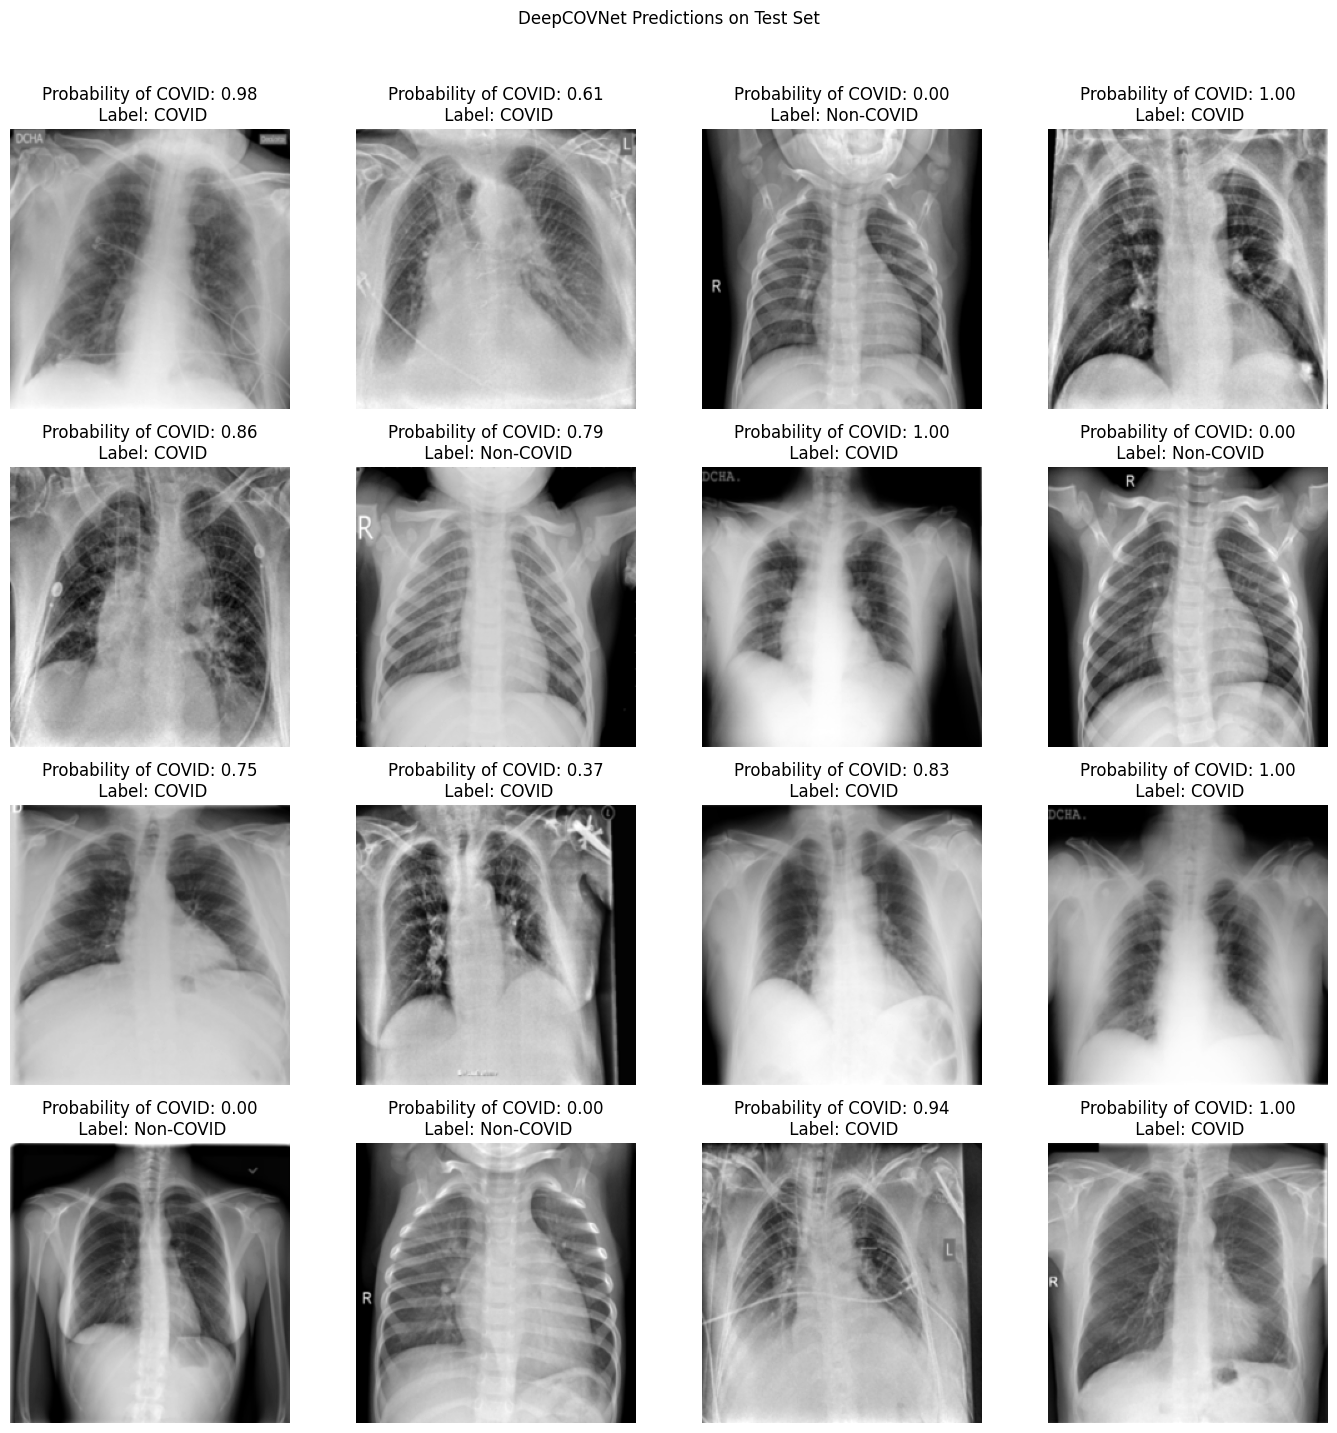

In [227]:
# Create a data loader for the DeepCOVNet model which requires reszie of 224 x 224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Create a new dataset with the transformations
test_dataset = COVID_QU_EX_Dataset(root_dir=QU_EX_DATA_PATH, transform=transform)

# Create DataLoaders for the training and etsting datasets
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # batch size must be 16 for visualizations


# Load the model using the best checkpoint 
covnet_model = DeepCOVNet(num_channels=CHANNELS_IMG, num_classes=NUM_CLASSES).to(DEVICE)
covnet_optimizer = torch.optim.Adam(covnet_model.parameters(), lr=LEARNING_RATE)
load_checkpoint(BEST_CHECKPOINT_DEEPCOVNET, covnet_model, covnet_optimizer, LEARNING_RATE)

# Display the images with their predicted probabilities
display_images_with_probabilities(covnet_model, test_loader)